In [46]:
from basepolygon_class import GoalPolygon
from shapely.geometry import Polygon, LineString
place_one = GoalPolygon('Жилой комплекс "Жулебино Парк" стройка')
place_two = GoalPolygon('Random Kvartal')
v = place_one.polygon
vv = place_two.polygon

/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

Геометрическое упрощение

In [48]:
def get_xy(s):

    x, y = s.centroid.coords.xy
    return x[0], y[0]

Здесь полигон в нуле не от центра

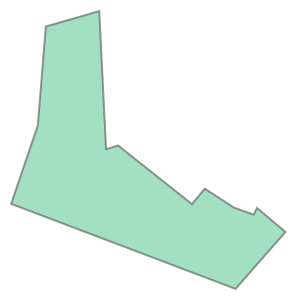

In [49]:
from shapely.affinity import translate
import numpy as np

s = v.simplify(10, preserve_topology=True)
ss = vv.simplify(10, preserve_topology=True)
x, y, _, _ = v.bounds
xx, yy, __, _ = vv.bounds
#x, y = get_xy(s)
st = translate(s, 0-x, 0-y)
stt = translate(ss, 0-xx, 0-yy)
stt

In [4]:
coor_list = (list(st.boundary.coords[0:len(st.boundary.coords) - 1]))

разбиение точек на группы по сегментам

In [5]:
from itertools import islice, cycle

def vec_search(point_list, key):
    cr = []
    n = list(islice(cycle(range(len(point_list))), 0, len(point_list) *2))
    for i in range(len(point_list)):
        v_one = [point_list[n[i]][0] - point_list[n[i + 1]][0], point_list[n[i]][1] - point_list[n[i + 1]][1], 0]
        v_two = [point_list[n[i + 1]][0] - point_list[n[i + 2]][0], point_list[n[i + 1]][1] - point_list[n[i + 2]][1],0]
        v_o_norm, v_t_norm = v_one / np.linalg.norm(v_one), v_two / np.linalg.norm(v_two)
        if np.cross(v_o_norm, v_t_norm)[2] < key:
            cr.append(n[i + 1])
        else:
            pass
    cross = [*cr, cr[0] + cr[-1] + 1]
    double_points = [*range(len(point_list)), *range(len(point_list))]
    points = [*point_list, *point_list]
    segments = [double_points[cross[c]:cross[c + 1]+1] for c in range(len(cross) - 1)]
    lines = [LineString(points[cross[c]:cross[c + 1]+1]) for c in range(len(cross) - 1)]
    return segments, lines

In [6]:
bb, ll = vec_search(coor_list, 0.5)
print(ll)

[<shapely.geometry.linestring.LineString object at 0x7faf6957f7f0>, <shapely.geometry.linestring.LineString object at 0x7faf6957c220>, <shapely.geometry.linestring.LineString object at 0x7faf6957c130>, <shapely.geometry.linestring.LineString object at 0x7faf6957f340>, <shapely.geometry.linestring.LineString object at 0x7faf6957d2d0>, <shapely.geometry.linestring.LineString object at 0x7faf6957f370>, <shapely.geometry.linestring.LineString object at 0x7faf6957d300>, <shapely.geometry.linestring.LineString object at 0x7faf6957f3a0>, <shapely.geometry.linestring.LineString object at 0x7faf6957f550>, <shapely.geometry.linestring.LineString object at 0x7faf6957f5b0>, <shapely.geometry.linestring.LineString object at 0x7faf6957f400>, <shapely.geometry.linestring.LineString object at 0x7faf6957c940>, <shapely.geometry.linestring.LineString object at 0x7faf6957f730>, <shapely.geometry.linestring.LineString object at 0x7faf6957d210>, <shapely.geometry.linestring.LineString object at 0x7faf6957c

In [7]:
def chains_base (point_list, parts):
    vectors =[]
    for i in parts:
        temp =[]
        for l in range(len(i)-1):
            vec = [point_list[i[l]][0] - point_list[i[l+1]][0], point_list[i[l]][1] - point_list[i[l+1]][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors

In [8]:
res_vec = chains_base(coor_list, bb)

SVD

In [9]:
from scipy.linalg import svd
import numpy as np
import torch

A = np.asarray(res_vec)

/var/folders/l7/52t7xngd2973k8x9_y55rmyh0000gn/T/ipykernel_23275/2655982256.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.asarray(res_vec)


In [10]:
class SvdItem:
    keys=["A", "U", "S", "Vh", "Sigma"]
    def __init__(self, m, collection=None, **kwargs):
        self.A = torch.tensor(m)
        self.collection=collection
        self.U = None
        self.S = None
        self.Vh = None
        self.Sigma = None
        self.svd(**kwargs)
        if collection is not None:
            self.id = f'{collection.id}:{len(collection.matrices)}'
            print(f'set item id: {self.id}')
            collection.A.append(self.A)



    def svd(self, **kwargs):
        U, S, Vh = torch.linalg.svd(self.A, **kwargs)
        Sigma = torch.diag(S)
        self.U, self.S, self.Vh, self.Sigma=U, S, Vh, Sigma
        print(self.U, self.S, self.Vh, self.Sigma)
        if self.collection:
            for v, k in zip([A, U, S, Vh, Sigma], self.__class__.keys):
                (self.collection.__dict__[k]).append(v)

        return U, S, Vh, Sigma
    def pack(self):
        self.collection.__dict__[self.__class__.__name__][self.collection.id]|={self.id:self}
        return self.id, self



class SvdPack:
    def __init__(self):
        self._matrices = []
        self.id = f'{0}:{0}'
        self.A, self.U, self.S, self.Vh, self.Sigma = [], [], [], [], []
        self.tree= {self.id:{}}



    @property
    def matrices(self):
        return self._matrices
    @matrices.setter
    def matrices(self, val, **kwargs):
        if len(val.shape) == 2:
            self._matrices.append(SvdItem(val, collection=self, **kwargs))
        else:
            for v in val:
                self._matrices.append(SvdItem(v, collection=self, **kwargs))

In [11]:
pck = SvdPack()

In [12]:
a_=np.asarray(res_vec, dtype=object)
pck.matrices = a_

tensor([[-0.0791,  0.9969],
        [ 0.9969,  0.0791]]) tensor([67.1437, 32.2108]) tensor([[ 0.1148, -0.9934],
        [-0.9934, -0.1148]]) tensor([[67.1437,  0.0000],
        [ 0.0000, 32.2108]])
set item id: 0:0:0
tensor([[-0.9992,  0.0412],
        [ 0.0412,  0.9992]]) tensor([141.5269,  28.6809]) tensor([[ 0.9961,  0.0882],
        [ 0.0882, -0.9961]]) tensor([[141.5269,   0.0000],
        [  0.0000,  28.6809]])
set item id: 0:0:1
tensor([[1.]]) tensor([77.6717]) tensor([[-0.9396, -0.3424],
        [-0.3424,  0.9396]]) tensor([[77.6717]])
set item id: 0:0:2
tensor([[1.]]) tensor([53.1286]) tensor([[-0.7384,  0.6743],
        [ 0.6743,  0.7384]]) tensor([[53.1286]])
set item id: 0:0:3
tensor([[ 0.5229,  0.2472, -0.1530,  0.2538,  0.7600],
        [ 0.0302,  0.3351, -0.6743, -0.6557, -0.0466],
        [-0.4987,  0.5425,  0.4969, -0.2824,  0.3610],
        [-0.6228,  0.1332, -0.5169,  0.5644,  0.0927],
        [-0.2984, -0.7173, -0.0879, -0.3277,  0.5303]]) tensor([68.2961, 63.9909])

In [13]:
pck_vh = pck.Vh

Работа с транспортированными точками

In [14]:
def matricies_check(matricies_list):
    matrix_checked = []
    for i in matricies_list:
        if i[0][1]<0 and i[1][0]>0 or i[0][1]>0 and i[1][0]<0 :
            matrix_checked.append(i)
        else:
            #ii = np.fliplr(i)*(-1)
            i[1]*= -1
            matrix_checked.append(i)
    return matrix_checked

identical_matricies = matricies_check(pck_vh)
identical_matricies

[tensor([[ 0.1148, -0.9934],
         [ 0.9934,  0.1148]]),
 tensor([[ 0.9961,  0.0882],
         [-0.0882,  0.9961]]),
 tensor([[-0.9396, -0.3424],
         [ 0.3424, -0.9396]]),
 tensor([[-0.7384,  0.6743],
         [-0.6743, -0.7384]]),
 tensor([[ 0.3947,  0.9188],
         [-0.9188,  0.3947]]),
 tensor([[-0.3567,  0.9342],
         [-0.9342, -0.3567]]),
 tensor([[-0.3778,  0.9259],
         [-0.9259, -0.3778]]),
 tensor([[-0.9334, -0.3588],
         [ 0.3588, -0.9334]]),
 tensor([[-0.9494,  0.3142],
         [-0.3142, -0.9494]]),
 tensor([[-0.9908, -0.1351],
         [ 0.1351, -0.9908]]),
 tensor([[ 0.8772, -0.4801],
         [ 0.4801,  0.8772]]),
 tensor([[-0.8178,  0.5755],
         [-0.5755, -0.8178]]),
 tensor([[-0.9954,  0.0960],
         [-0.0960, -0.9954]]),
 tensor([[-0.9437, -0.3309],
         [ 0.3309, -0.9437]]),
 tensor([[-0.3723,  0.9281],
         [-0.9281, -0.3723]]),
 tensor([[-0.9347, -0.3553],
         [ 0.3553, -0.9347]]),
 tensor([[ 0.1574,  0.9875],
         [-

In [15]:
def transform_chains_from_vh(chains, t):
    chains_t=[]
    for i, clust in enumerate(chains):
        _t=[]
        for j in clust:
            _ = t[i] @ np.asarray(coor_list[j])
            _t.append(np.asarray(_).tolist())
        chains_t.append(_t)
    return chains_t

p_t = transform_chains_from_vh(bb, identical_matricies)

In [16]:
def chains_ (point_list):
    vectors =[]
    for i in point_list:
        temp =[]
        for l in range(len(i)-1):
            vec = [i[l][0] - i[l+1][0], i[l][1] - i[l+1][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors

v_t = chains_(p_t)
# not transformed vec
v_ = res_vec

In [17]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angle (v_tr, v_b):
    ang =[]
    for j, i in enumerate(v_tr):
        for ind, val in enumerate(i):
            ang.append(angle_between(val, v_b[j][ind]))
            break
    return ang

angl = angle(v_t, res_vec)

In [18]:

scope = np.asarray(angl)/np.linalg.norm(angl)
r = np.round(scope*len(angl),0)
labels=[]
l = np.unique(r).tolist()
for i in r:
    labels.append(l.index(i))
print(labels)


[3, 0, 5, 5, 2, 4, 4, 5, 5, 6, 1, 5, 6, 5, 4, 5, 3, 3]


Display

In [30]:
from collections import defaultdict
from shapely.geometry import MultiLineString
d_ = defaultdict(list)

for la, l in zip(labels, ll):
    d_[la].append(l)

d_


defaultdict(list,
            {3: [<shapely.geometry.linestring.LineString at 0x7faf6957f7f0>,
             0: [<shapely.geometry.linestring.LineString at 0x7faf6957c220>],
             5: [<shapely.geometry.linestring.LineString at 0x7faf6957c130>,
             2: [<shapely.geometry.linestring.LineString at 0x7faf6957d2d0>],
             4: [<shapely.geometry.linestring.LineString at 0x7faf6957f370>,
             6: [<shapely.geometry.linestring.LineString at 0x7faf6957f5b0>,
             1: [<shapely.geometry.linestring.LineString at 0x7faf6957f400>]})

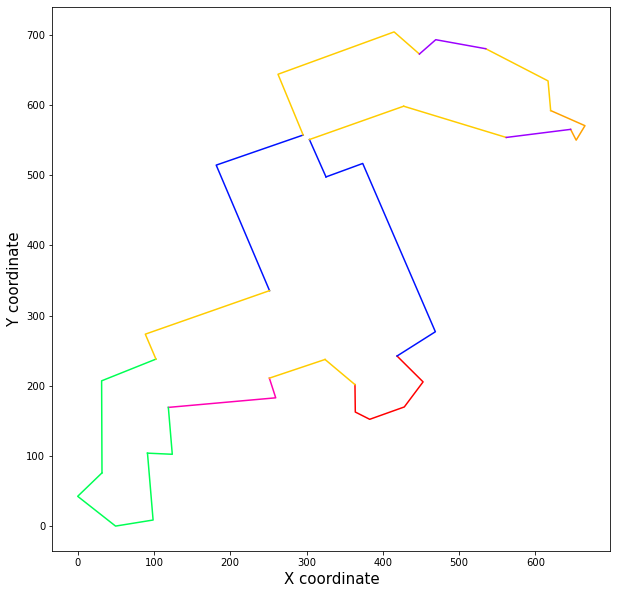

In [44]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)
for d in d_[0]:
    ax.plot(*d.xy, label='LineString', color='#ff00b4')
for d in d_[1]:
    ax.plot(*d.xy, label='LineString', color='#ffa200')
for d in d_[2]:
    ax.plot(*d.xy, label='LineString', color='#ff0000')
for d in d_[3]:
    ax.plot(*d.xy, label='LineString', color='#00ff54')
for d in d_[4]:
    ax.plot(*d.xy, label='LineString', color='#0012ff')
for d in d_[5]:
    ax.plot(*d.xy, label='LineString', color='#ffcc00')
for d in d_[6]:
    ax.plot(*d.xy, label='LineString', color='#9c00ff')

plt.show()